In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os, csv, json
import pandas as pd
import scipy.optimize as sp
import itertools

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from scipy.ndimage import gaussian_filter1d
import scipy.signal as sg

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl

%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/aux_funcs.py
%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/RSRG_class.py
%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/bdry_log_aux_funcs.py

In [72]:
#run_dir = "bdry_sweep_fine/"
run_dir = "/home/guaravtenkila/Disorder_sims/Ising_RSRG/log_bdry_output/bdry_mag_runs/"
#run_dir = "/home/guaravtenkila/Disorder_sims/lisa_outputs/log_OBC_runs/"

log_file = pd.read_csv(run_dir+"bdry_log_file.csv")
ts_list = log_file['ts'].tolist()
#log_file['L'].tolist()
selected_files = log_file
selected_files

ts_list = selected_files['ts'].tolist()
n_runs_list = selected_files['n_runs'].tolist()
L_list = selected_files['L'].tolist()

selected_files

,L,steps,w_blk,w_bdry,w_mixed,n_runs,runtime,ts
0,"(10, 10)",99,6.6,2.00,6.6,960,5.361272,991202481020.066.0
1,"(10, 10)",99,6.6,2.15,6.6,960,5.198178,991210221021.566.0
2,"(10, 10)",99,6.6,2.30,6.6,960,5.398989,991217741023.066.0
3,"(10, 10)",99,6.6,2.45,6.6,960,5.356492,991225401024.566.0
4,"(10, 10)",99,6.6,2.60,6.6,960,5.290488,991232961026.066.0
5,"(10, 10)",99,6.6,2.75,6.6,960,5.453458,991240481027.566.0
6,"(10, 10)",99,6.6,2.90,6.6,960,5.161027,991248191029.066.0
7,"(20, 20)",399,6.6,2.00,6.6,960,28.776215,991255682020.066.0
8,"(20, 20)",399,6.6,2.15,6.6,960,28.290419,991286582021.566.0
9,"(20, 20)",399,6.6,2.30,6.6,960,28.334287,991316972023.066.0


In [55]:
def get_active_clust_sizes(reverse_dict, active_clust, track_decimated_only=False):
    active_clust_size = []
    for clust in reverse_dict.values():
        if clust is None: continue
        elif active_clust[clust].sum()==0: continue
        elif track_decimated_only and len(clust)==1: continue
        else:
            active_clust_size.append(len(clust))
    return np.array(active_clust_size)

def get_all_clust_sizes(reverse_dict, ignore_singlets=False):
    clust_size = []
    for clust in reverse_dict.values():
        if clust is None: continue
        if ignore_singlets: 
            if len(clust)==1: continue
        else: clust_size.append(len(clust))
    return np.array(clust_size)

def get_all_clust_sizes_blk(reverse_dict, bdry_dict):
    clust_size = []
    for clust in reverse_dict.values():
        if clust is None: continue
        if bdry_dict[clust[0]]: continue
        else: clust_size.append(len(clust))
    return np.array(clust_size)
        

def get_binder_cumulant(reverse_dict, active_clust, L):
    acs_list = get_active_clust_sizes(reverse_dict, active_clust)/L**2
    return 1-(acs_list**4).sum()/((acs_list**2).sum())**2

def get_custom_cumulant(reverse_dict, L):
    clust_size_list = get_all_clust_sizes(reverse_dict)
    second_cum = (clust_size_list**2).sum() - L**4
    fourth_cum = (clust_size_list**4).sum()
    return fourth_cum/second_cum**2

def second_cumulant(X):
    return ((X-X.mean())**2).mean()

def fourth_cumulant(X):
    return ((X-X.mean())**4).mean() - 3*(((X-X.mean())**2).mean())**2

In [5]:
#L_list = [40, 60, 80, 100, 120, 150]
c_dict = {150:'red', 120:'blue', 60:'green', 80:'cyan', 40:'orange', 100:'magenta', 50:'brown'}
L_list = [40]

w_vals_comp = []
active_clust_var_comp = []
binder_comp = []
binder_comp_alt = []
binder_comp_alt2 = []
custom_comp = []
all_clust_var_comp = []

for L in L_list:
    fixed_length_slice = log_file[lambda df: (df['L'] == '('+str(L)+', 20)')]
    #fixed_length_slice = log_file[lambda df: (df['L'] == L+1)]
    #fixed_length_slice = log_file[lambda df: (df['L'] == L)]
    ts_list = fixed_length_slice['ts'].tolist()
    w_vals = fixed_length_slice['w_bdry'].tolist()
    var_acs = []
    var_allcs = []
    binder_avg = []
    binder_alt = []
    binder_alt2 = []
    custom_avg = []

    for index, ts in enumerate(ts_list):

        with open(run_dir+"LIsingB_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list, bdry_dict_list, active_clust_list = [], [], [], []
        

        for core_pair in clust_list_final:
            clust_list_temp = core_pair[0]
            reverse_list_temp = core_pair[1]
            bdry_temp = core_pair[2]
            active_temp = core_pair[3]
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp
            bdry_dict_list+=bdry_temp
            active_clust_list+=active_temp
                         
        #active_clust_size_var_list = np.array([get_active_clust_sizes(rd, active_clust_list[i]).sum() for i, rd in enumerate(reverse_dict_list)])
        #all_clust_size_var_list = np.array([get_all_clust_sizes(rd).sum() for rd in reverse_dict_list])
        #binder_cum_list = np.array([get_binder_cumulant(rd, active_clust_list[i], L) for i,rd in enumerate(reverse_dict_list)])
        
        order_param_list = np.array([get_active_clust_sizes(rd, active_clust_list[i]).sum() for i, rd in enumerate(reverse_dict_list)])/(L**2)
        
        binder_calc_alt = (order_param_list**4).mean()/(3*((order_param_list**2).mean())**2)
        order_param_list = 2*order_param_list - 1
        binder_calc_alt2 = (order_param_list**4).mean()/(3*((order_param_list**2).mean())**2)
        #var_acs.append(active_clust_size_var_list.mean()/L**2)
        #var_allcs.append(all_clust_size_var_list.mean()/L**2)
        #binder_avg.append(binder_cum_list.mean())
        binder_alt.append(binder_calc_alt)
        binder_alt2.append(binder_calc_alt2)
        
        custom_cum_list = np.array([get_custom_cumulant(rd, L) for rd in reverse_dict_list])
        custom_avg.append(custom_cum_list.mean())
    w_vals_comp.append(w_vals)
    #active_clust_var_comp.append(var_acs)
    #all_clust_var_comp.append(var_allcs)
    #binder_comp.append(binder_avg)
    binder_comp_alt.append(binder_alt)
    binder_comp_alt2.append(binder_alt2)
    custom_comp.append(custom_avg)

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(8, 6))
for i, L in enumerate(L_list):
    #plt.scatter(w_vals_comp[i], active_clust_var_comp[i], c=c_dict[L], label='L='+str(L), s=30)
    #plt.scatter(w_vals_comp[i], binder_comp_alt[i], c=c_dict[L], marker='s', s=30)
    #plt.scatter(w_vals_comp[i], binder_comp[i], c=c_dict[L], s=30, marker='^')
    #plt.scatter(w_vals_comp[i], binder_comp_alt2[i], c=c_dict[L], marker='^', s=30)
    plt.scatter(w_vals_comp[i], custom_comp[i], c=c_dict[L])
    
plt.ylabel(r"$\langle\sum N^4\rangle / \langle\sum N^2 - L^4\rangle$")
plt.xlabel("Width of bond distriburion")
plt.title("Ratio of cluster size cumulants, disorder averaged")
#plt.xlim(4.5, 5.5)
#plt.ylim(0, 0.1)
#plt.legend()

In [71]:
#L_list = [40, 60, 80, 100, 120, 150]
c_dict = {150:'red', 120:'blue', 60:'green', 80:'cyan', 40:'orange', 100:'magenta', 50:'brown'}
L_list = [40]

w_vals_comp = []
order_param_comp = []
second_cum_comp = []
fourth_cum_comp = []

for L in L_list:
    fixed_length_slice = log_file[lambda df: (df['L'] == '('+str(L)+', 20)')]
    #fixed_length_slice = log_file[lambda df: (df['L'] == L+1)]
    #fixed_length_slice = log_file[lambda df: (df['L'] == L)]
    ts_list = fixed_length_slice['ts'].tolist()
    w_vals = fixed_length_slice['w_bdry'].tolist()
    order_param = []
    second_cum = []
    fourth_cum = []

    for index, ts in enumerate(ts_list):

        with open(run_dir+"LIsingB_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list, bdry_dict_list, active_clust_list = [], [], [], []
        

        for core_pair in clust_list_final:
            clust_list_temp = core_pair[0]
            reverse_list_temp = core_pair[1]
            bdry_temp = core_pair[2]
            active_temp = core_pair[3]
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp
            bdry_dict_list+=bdry_temp
            active_clust_list+=active_temp
                         
        #X = np.array([np.max(get_all_clust_sizes_blk(rd, bdry_dict_list[i]))/np.sum(~bdry_dict_list[i]) for i, rd in enumerate(reverse_dict_list)])
        X = np.array([np.max(get_all_clust_sizes(rd)) for rd in reverse_dict_list])
        
        order_param.append(X.mean())
        second_cum.append(second_cumulant(X))
        fourth_cum.append(fourth_cumulant(X))
    w_vals_comp.append(w_vals)
    second_cum_comp.append(second_cum)
    fourth_cum_comp.append(fourth_cum)

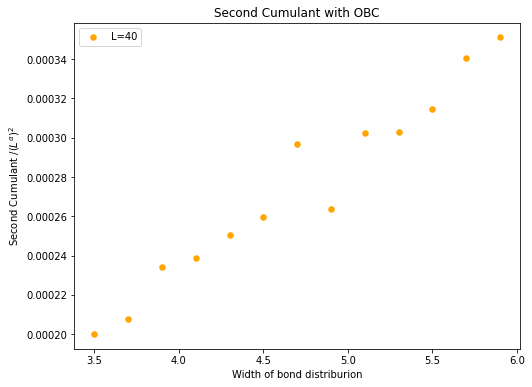

In [72]:
plt.figure(figsize=(8, 6))
for i, L in enumerate(L_list):
    plt.scatter(w_vals_comp[i], np.array(second_cum_comp[i])/L**4, c=c_dict[L], marker='o', s=30, label="L="+str(L))
    #plt.scatter(w_vals_comp[i], np.array(fourth_cum_comp[i])/L**8, c=c_dict[L], marker='s', s=30, label="L="+str(L))
    #plt.scatter(w_vals_comp[i], 2 - np.array(fourth_cum_comp[i])/np.array(second_cum_comp[i])**2/3, c=c_dict[L], marker='o', s=30, label="L="+str(L))
    
plt.ylabel(r"Second Cumulant /$(L^\alpha)^2$")
plt.xlabel("Width of bond distriburion")
plt.title("Second Cumulant with OBC")
#plt.xlim(4.5, 5.5)
#plt.ylim(0, 0.1)
plt.legend()
plt.savefig("OBC_second_cumulant")

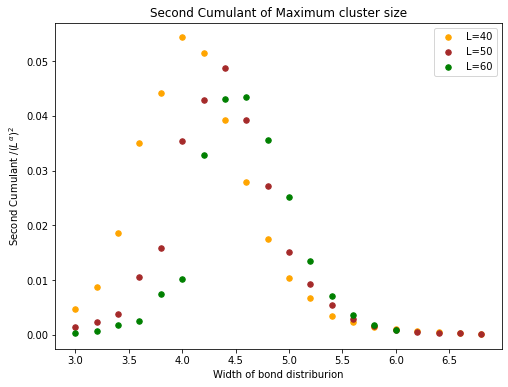

In [61]:
plt.figure(figsize=(8, 6))
for i, L in enumerate(L_list):
    plt.scatter(w_vals_comp[i], np.array(second_cum_comp[i]), c=c_dict[L], marker='o', s=30, label="L="+str(L))
    #plt.scatter(w_vals_comp[i], np.array(fourth_cum_comp[i])/L**8, c=c_dict[L], marker='s', s=30, label="L="+str(L))
    #plt.scatter(w_vals_comp[i], 2 - np.array(fourth_cum_comp[i])/np.array(second_cum_comp[i])**2/3, c=c_dict[L], marker='o', s=30, label="L="+str(L))
    
plt.ylabel(r"Second Cumulant /$(L^\alpha)^2$")
plt.xlabel("Width of bond distriburion")
plt.title("Second Cumulant of Maximum cluster size")
#plt.xlim(4.5, 5.5)
#plt.ylim(0, 0.1)
plt.legend()
plt.savefig("OBC_second_cumulant")

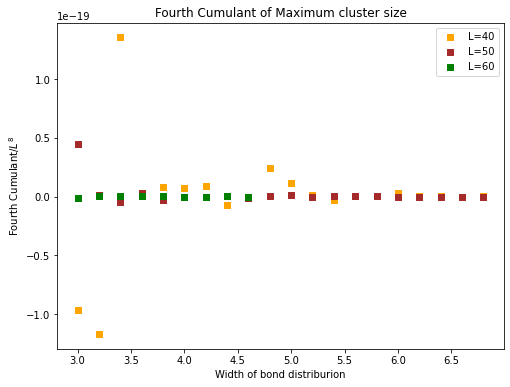

In [53]:
plt.figure(figsize=(8, 6))
for i, L in enumerate(L_list):
    plt.scatter(w_vals_comp[i], np.array(second_cum_comp[i]), c=c_dict[L], marker='o', s=30, label="L="+str(L))
    #plt.scatter(w_vals_comp[i], np.array(fourth_cum_comp[i]), c=c_dict[L], marker='s', s=30, label="L="+str(L))
    #plt.scatter(w_vals_comp[i], 2 - np.array(fourth_cum_comp[i])/np.array(second_cum_comp[i])**2/3, c=c_dict[L], marker='o', s=30, label="L="+str(L))
    
plt.ylabel("Fourth Cumulant/$L^8$")
plt.xlabel("Width of bond distriburion")
plt.title("Fourth Cumulant of Maximum cluster size")
#plt.xlim(4.5, 5.5)
#plt.ylim(0, 0.1)
plt.legend()

In [7]:
def get_bdry_magnetization(mag_list, clust_dict_list, reverse_dict_list, Lx, Ly):
    bdry_mag_list = []
    for ind, site in enumerate(mag_list):
        mag_clust = np.array(reverse_dict_list[ind][clust_dict_list[ind][site]])
        bdry_mag_list.append((mag_clust<Ly).sum())
    return np.array(bdry_mag_list)/(Lx*Ly)

In [73]:
Lx_list = [10]
Ly_list = [10, 20, 30, 40, 15]
c_dict = {30: 'orange', 20:'red', 40:'blue', 10:'green', 32:'magenta', 60:'purple'}
#Lx = 40


w_vals_comp = []
lcs_comp = []
mag_err_comp = []
magnetization_comp = []
marker_comp = []

for Lx in Lx_list:
    for Ly in Ly_list:
        if Lx==60: run_dir = "/home/guaravtenkila/Disorder_sims/lisa_outputs/log_OBC_runs/"
        Lx = Ly
        log_file = pd.read_csv(run_dir+"bdry_log_file.csv")
        #Lx, Ly = Lx, L
        rect_side = "(%d, %d)"%(Lx, Ly)
        fixed_length_slice = log_file[lambda df: (df['L']==rect_side)]
        #fixed_length_slice = log_file[lambda df: (df['L'] == L)]
        ts_list = fixed_length_slice['ts'].tolist()
        n_runs_list = fixed_length_slice['n_runs'].tolist()
        #misc_notes = fixed_length_slice['misc'].tolist()

        w_vals = fixed_length_slice['w_bdry'].tolist()
        largest_clust_size = []
        #largest_clust_size_err = []
        magnetization = []
        mag_err = []

        w_list = []
        c_list = []
        m_list = []


        for index, ts in enumerate(ts_list):

            #if str(30) in misc_notes[index]: continue#m_type, c_type = 'o', 'red'
            #elif "no" in misc_notes[index]: m_type, c_type = 'x', 'blue'
            #m_list.append(m_type)

            with open(run_dir+"LIsingB_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
                clust_list_final = pickle.load(fp)

            #print(input_dict)
            clust_dict_list, reverse_dict_list, mag_list = [], [], []

            for core_pair in clust_list_final:
                clust_list_temp  = core_pair[0] 
                reverse_list_temp = core_pair[1]
                mag_temp = core_pair[-3]
                clust_dict_list+=clust_list_temp
                reverse_dict_list+=reverse_list_temp
                mag_list+=mag_temp

            bdry_mag_list = get_bdry_magnetization(mag_list, clust_dict_list, reverse_dict_list, Lx, Ly)


            magnetization.append(bdry_mag_list.mean())
            mag_err.append(bdry_mag_list.std()/np.sqrt(n_runs_list[index]-1))
            w_list.append(w_vals[index])
            #c_list.append(c_dict[L])

        w_vals_comp.append(w_list)
        magnetization_comp.append(magnetization)
        mag_err_comp.append(mag_err)
        #marker_comp.append(m_list)


In [44]:
w_vals_2 = w_vals_comp
mag_comp_2 = magnetization_comp
mag_err_2 = mag_err_comp

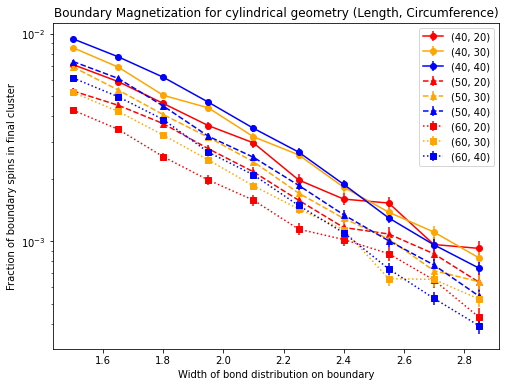

In [52]:
plt.figure(figsize=(8, 6))
m_dict = {40:'o', 50:'^', 60:'s', 80:'^'}
l_dict = {40:'solid', 50:'dashed', 60:'dotted'}

for i, Lx in enumerate(Lx_list):
    for j, Ly in enumerate(Ly_list):
        ind = len(Ly_list)*i+j
        #print(ind)
        x_dat = np.array(w_vals_comp[ind])
        y_dat = np.array(magnetization_comp[ind])[x_dat.argsort()]
        y_err = np.array(mag_err_comp[ind])[x_dat.argsort()]
        plt.errorbar(x_dat[x_dat.argsort()], y_dat, yerr=y_err, marker=m_dict[Lx], linestyle=l_dict[Lx],label='('+str(Lx)+', '+str(Ly)+')', c=c_dict[Ly])
        continue
        x_dat = np.array(w_vals_2[ind])
        y_dat = np.array(mag_comp_2[ind])[x_dat.argsort()]
        y_err = np.array(mag_err_2[ind])[x_dat.argsort()]
        plt.errorbar(x_dat[x_dat.argsort()], y_dat, yerr=y_err, marker='s', c=c_dict[Ly], linestyle='--')
plt.title("Boundary Magnetization for cylindrical geometry (Length, Circumference)")
plt.xlabel("Width of bond distribution on boundary")
plt.ylabel("Fraction of boundary spins in final cluster")
plt.legend()
#plt.xlim(1.5, 3)
#plt.ylim(1e-3, 1e-2)
plt.yscale('log')
#plt.savefig("bdry_mag_coarse_Lblk40")


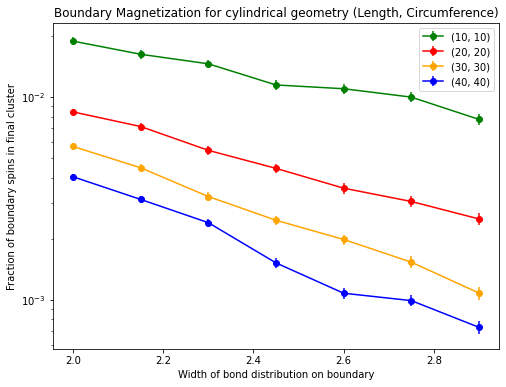

In [64]:
plt.figure(figsize=(8, 6))

for j, Ly in enumerate(Ly_list):
    ind = j
    #print(ind)
    x_dat = np.array(w_vals_comp[ind])
    y_dat = np.array(magnetization_comp[ind])[x_dat.argsort()]
    y_err = np.array(mag_err_comp[ind])[x_dat.argsort()]
    plt.errorbar(x_dat[x_dat.argsort()], y_dat, yerr=y_err, marker=m_dict[Lx], linestyle=l_dict[Lx],label='('+str(Ly)+', '+str(Ly)+')', c=c_dict[Ly])

plt.title("Boundary Magnetization for cylindrical geometry (Length, Circumference)")
plt.xlabel("Width of bond distribution on boundary")
plt.ylabel("Fraction of boundary spins in final cluster")
plt.legend()
#plt.xlim(1.5, 3)
#plt.ylim(1e-3, 1e-2)
plt.yscale('log')
#plt.savefig("bdry_mag_coarse_Lblk40")


<ErrorbarContainer object of 3 artists>

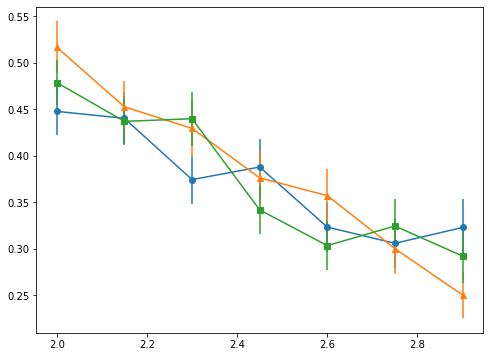

In [82]:
plt.figure(figsize=(8, 6))

x_arr = []
y_arr = []
y_err_comp = []
for j, Ly in enumerate(Ly_list):
    ind = j
    #print(ind)
    x_dat = np.array(w_vals_comp[ind])
    y_dat = np.array(magnetization_comp[ind])[x_dat.argsort()]
    y_err = np.array(mag_err_comp[ind])[x_dat.argsort()]
    
    y_arr.append(y_dat)
    x_arr.append(x_dat)
    y_err_comp.append(y_err)
    
plt.errorbar(x_arr[1], y_arr[1]/y_arr[0], yerr=(y_arr[1]/y_arr[0])*np.sqrt((y_err_comp[1]/y_arr[1])**2+(y_err_comp[0]/y_arr[0])**2), marker='o')
plt.errorbar(x_arr[2], y_arr[2]/y_arr[4], yerr=(y_arr[2]/y_arr[4])*np.sqrt((y_err_comp[4]/y_arr[4])**2+(y_err_comp[2]/y_arr[2])**2), marker='^')
plt.errorbar(x_arr[3], y_arr[3]/y_arr[1], yerr=(y_arr[3]/y_arr[1])*np.sqrt((y_err_comp[1]/y_arr[1])**2+(y_err_comp[3]/y_arr[3])**2), marker='s')